In [34]:
documents = [
    "Machine learning is a subset of artificial intelligence that enables computers to learn from data.",
    "Deep learning uses neural networks with many layers to model complex patterns in data.",
    "Natural language processing helps machines understand and generate human language.",
    "Data science combines statistics, programming, and domain expertise to extract insights.",
    "Big data refers to extremely large datasets that require special tools for processing.",
    "Python is a popular programming language for data analysis and machine learning.",
    "TensorFlow and PyTorch are widely used frameworks for building deep learning models.",
    "Text mining involves extracting useful information from unstructured text data.",
    "Clustering algorithms group similar data points together without prior labels.",
    "Supervised learning requires labeled data to train predictive models.",
    "AI ethics focuses on fairness, transparency, and accountability in machine learning systems.",
    "Cloud computing provides scalable resources for storing and analyzing big data."
]

In [35]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Initialize stopwords and punctuation
stop_words = set(stopwords.words('english'))
punct = set(string.punctuation)

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in punct])
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

# Preprocess all documents
processed_docs = [preprocess_text(doc) for doc in documents]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Re-join tokens for sklearn
processed_docs_for_tfidf = [' '.join(doc) for doc in processed_docs]

# Compute TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(processed_docs_for_tfidf)
feature_names = vectorizer.get_feature_names_out()

# Get top 10 words per document
top_words_per_doc = []
for i in range(tfidf_matrix.shape[0]):
    doc_scores = tfidf_matrix[i].toarray()[0]
    word_scores = [(feature_names[j], doc_scores[j]) for j in range(len(feature_names)) if doc_scores[j] > 0]
    sorted_words = sorted(word_scores, key=lambda x: -x[1])
    top_10 = [word for word, score in sorted_words[:10]]
    top_words_per_doc.append(top_10)
    print(f"Document {i+1} Top 10 TF-IDF Words: {top_10}\n")

Document 1 Top 10 TF-IDF Words: ['artificial', 'computers', 'enables', 'intelligence', 'learn', 'subset', 'machine', 'learning', 'data']

Document 2 Top 10 TF-IDF Words: ['complex', 'layers', 'many', 'model', 'networks', 'neural', 'patterns', 'uses', 'deep', 'learning']

Document 3 Top 10 TF-IDF Words: ['language', 'generate', 'helps', 'human', 'machines', 'natural', 'understand', 'processing']

Document 4 Top 10 TF-IDF Words: ['combines', 'domain', 'expertise', 'extract', 'insights', 'science', 'statistics', 'programming', 'data']

Document 5 Top 10 TF-IDF Words: ['datasets', 'extremely', 'large', 'refers', 'require', 'special', 'tools', 'big', 'processing', 'data']

Document 6 Top 10 TF-IDF Words: ['analysis', 'popular', 'python', 'language', 'programming', 'machine', 'learning', 'data']

Document 7 Top 10 TF-IDF Words: ['building', 'frameworks', 'pytorch', 'tensorflow', 'used', 'widely', 'deep', 'models', 'learning']

Document 8 Top 10 TF-IDF Words: ['text', 'extracting', 'informati

In [37]:
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Train Word2Vec model
model = Word2Vec(sentences=processed_docs, vector_size=100, window=5, min_count=1, workers=4, epochs=100)

# Find most similar words to "data"
similar_to_data = model.wv.most_similar('data', topn=5)
print("Words most similar to 'data':", similar_to_data)

# Similarly for 'analysis' or 'learning'
try:
    similar_to_analysis = model.wv.most_similar('analysis', topn=5)
    print("Words most similar to 'analysis':", similar_to_analysis)
except KeyError:
    print("Word 'analysis' not in vocabulary.")

try:
    similar_to_learning = model.wv.most_similar('learning', topn=5)
    print("Words most similar to 'learning':", similar_to_learning)
except KeyError:
    print("Word 'learning' not in vocabulary.")

Words most similar to 'data': [('learning', 0.5856596827507019), ('widely', 0.5734493136405945), ('datasets', 0.559103786945343), ('big', 0.5444273948669434), ('networks', 0.5403631329536438)]
Words most similar to 'analysis': [('deep', 0.32833847403526306), ('extremely', 0.3036517798900604), ('insights', 0.28645384311676025), ('large', 0.2803136110305786), ('data', 0.25648823380470276)]
Words most similar to 'learning': [('data', 0.5856596231460571), ('large', 0.527137815952301), ('statistics', 0.5176563858985901), ('points', 0.4809170663356781), ('insights', 0.4637333154678345)]


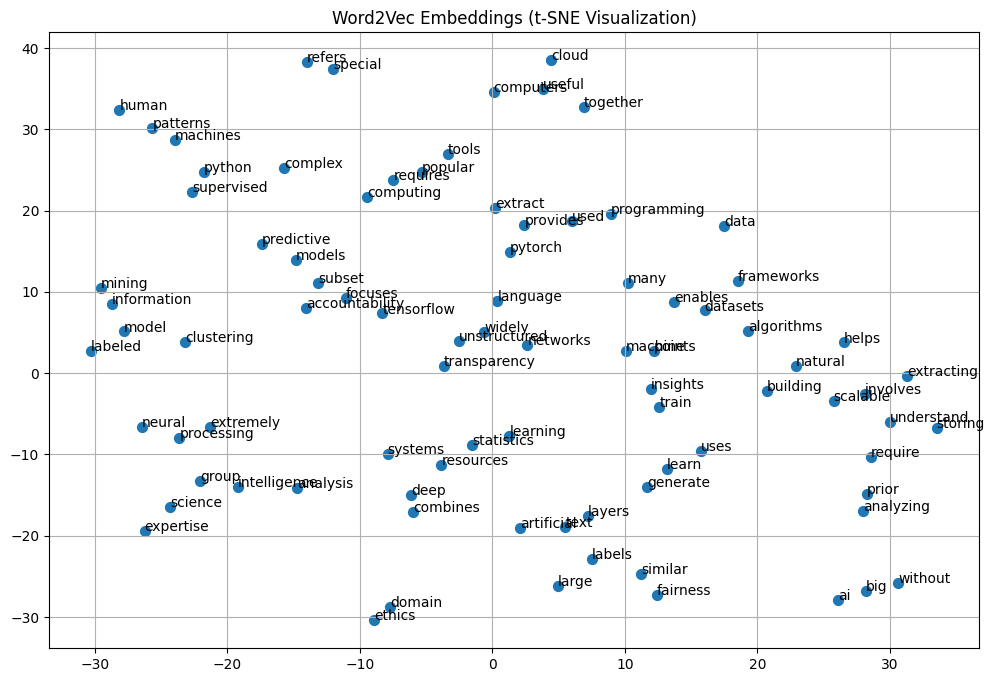

In [38]:
from sklearn.manifold import TSNE

# Get all word vectors
words = list(model.wv.key_to_index.keys())
word_vectors = np.array([model.wv[word] for word in words])

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
word_vec_2d = tsne.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(word_vec_2d[:, 0], word_vec_2d[:, 1], s=50)

# Annotate words
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vec_2d[i, 0], word_vec_2d[i, 1]), fontsize=10)

plt.title("Word2Vec Embeddings (t-SNE Visualization)")
plt.grid(True)
plt.show()

In [39]:
from gensim import corpora
from gensim.models import LdaModel

# Create dictionary and corpus
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train LDA model (3–5 topics)
num_topics = 5
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# Print top 5 words per topic
topics = lda_model.print_topics(num_words=5)
for topic_id, topic_words in topics:
    print(f"Topic {topic_id + 1}: {topic_words}")


print("\nTopic Distributions: ")

doc_topic_distribution = []
for i, doc_bow in enumerate(corpus):
    topic_probs = lda_model.get_document_topics(doc_bow)
    dominant_topic = max(topic_probs, key=lambda x: x[1])
    topic_id = dominant_topic[0]
    prob = dominant_topic[1]
    doc_topic_distribution.append((i+1, topic_id + 1, prob))
    print(f"Document {i+1} → Topic {topic_id + 1} (Confidence: {prob:.3f})")

Topic 1: 0.064*"data" + 0.035*"predictive" + 0.035*"supervised" + 0.035*"extract" + 0.035*"train"
Topic 2: 0.070*"data" + 0.026*"together" + 0.026*"clustering" + 0.026*"analysis" + 0.026*"programming"
Topic 3: 0.058*"learning" + 0.040*"language" + 0.040*"deep" + 0.022*"data" + 0.022*"machine"
Topic 4: 0.045*"data" + 0.045*"big" + 0.045*"analyzing" + 0.045*"scalable" + 0.045*"provides"
Topic 5: 0.062*"data" + 0.062*"text" + 0.034*"machine" + 0.034*"learn" + 0.034*"mining"

Topic Distributions: 
Document 1 → Topic 5 (Confidence: 0.972)
Document 2 → Topic 3 (Confidence: 0.980)
Document 3 → Topic 3 (Confidence: 0.976)
Document 4 → Topic 1 (Confidence: 0.972)
Document 5 → Topic 2 (Confidence: 0.976)
Document 6 → Topic 2 (Confidence: 0.970)
Document 7 → Topic 3 (Confidence: 0.976)
Document 8 → Topic 5 (Confidence: 0.972)
Document 9 → Topic 2 (Confidence: 0.976)
Document 10 → Topic 1 (Confidence: 0.969)
Document 11 → Topic 3 (Confidence: 0.976)
Document 12 → Topic 4 (Confidence: 0.970)


In [40]:
!pip install gensim pyLDAvis nltk

In [41]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)